### Readme
notebook que carga y analiza el fichero JSON con información de repositorios
los datos se han obtenido via API GraphQL y REST API de github

### Carga de librerías y fichero de datos. comprobaciones básicas

In [16]:
# imports de librerías requeridas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json
from tabulate import tabulate
import locale

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.stats import randint


In [2]:
#pd.set_option('display.precision', 2)  # Configurar la precisión de decimales

# Configurar la visualización para que los números se muestren en formato europeo
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))

In [3]:
DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean.json'

# Fichero df_clean.sjon contenia fechas en formato UNIX seconds. Se convirtió a DateTime de nuevo en el siguiente fichero
#DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean_w_correct_date.json'

In [4]:
# Leer el archivo JSON y convertir las columnas de fecha
df = pd.read_json(DATA_FILE, orient='records', lines=True, convert_dates=['createdAt', 'pushedAt', 'updatedAt'])

In [5]:
df_copy=df.copy()

In [8]:
# Definición de las columnas numéricas y categóricas según la estructura de df_copy
# son las varialbes seleccionadas en E3

columnas_numericas = [
    'assignableUsers',
    'contributors',
    'deployments',
    'diskUsage',
    'environments',
    'milestones',
    'releases',
    'language_count'
]

# Definición de columnas categóricas
columnas_categoricas = [
    'hasIssuesEnabled',
    'hasProjectsEnabled',
    'hasSponsorshipsEnabled',
    'hasWikiEnabled',
    'isInOrganization',
    'isTemplate'
]

lennum=len(columnas_numericas)
lencat=len(columnas_categoricas)
# Mostrar los resultados
print("Columnas Numéricas:")
print(lennum, columnas_numericas)
print("\nColumnas Categóricas:")
print(lencat, columnas_categoricas)
print("total: ",lennum+lencat)
columns_to_cluster=columnas_numericas+columnas_categoricas

Columnas Numéricas:
8 ['assignableUsers', 'contributors', 'deployments', 'diskUsage', 'environments', 'milestones', 'releases', 'language_count']

Columnas Categóricas:
6 ['hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'hasWikiEnabled', 'isInOrganization', 'isTemplate']
total:  14


In [9]:
# convertir boolean a numero

# Crear una copia del dataframe
df_copy_cluster = df_copy.copy()

# Transformar booleanos en números (0 y 1)
df_copy_cluster[columnas_categoricas] = df_copy_cluster[columnas_categoricas].astype(int)

# Verificar la transformación
df_copy_cluster[columns_to_cluster].head()

,assignableUsers,contributors,deployments,diskUsage,environments,milestones,releases,language_count,hasIssuesEnabled,hasProjectsEnabled,hasSponsorshipsEnabled,hasWikiEnabled,isInOrganization,isTemplate
0,4,22,0,55148,0,0,26,5,1,1,0,1,1,0
1,1,15,0,9068,0,0,4,2,1,1,1,1,0,0
2,4,4,0,548,0,0,4,2,1,1,0,1,1,0
3,1,11,100,310,2,0,1,2,1,1,1,1,1,0
4,1,10,0,8118,0,0,0,4,1,1,0,0,0,0


In [10]:
# outliers
def eliminar_outliers(df, columns):
    df_clean = df.copy()
    LIM=3
    for col in columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - LIM * IQR
            upper_bound = Q3 + LIM * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

In [11]:
# Eliminar outliers
df_clean = eliminar_outliers(df_copy_cluster, columns_to_cluster)

# Mostrar el tamaño del DataFrame limpio
print(f'Tamaño original: {df_copy.shape[0]}, Tamaño después de eliminar outliers: {df_clean.shape[0]}')

Tamaño original: 37120, Tamaño después de eliminar outliers: 12290


In [13]:
df_clean[columns_to_cluster].describe()

,assignableUsers,contributors,deployments,diskUsage,environments,milestones,releases,language_count,hasIssuesEnabled,hasProjectsEnabled,hasSponsorshipsEnabled,hasWikiEnabled,isInOrganization,isTemplate
count,"12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00","12.290,00"
mean,"1,22","2,79","0,00","5.397,92","0,00","0,00","0,65","2,39","1,00","1,00","0,00","1,00","0,00","0,00"
std,"0,70","3,21","0,00","9.264,85","0,00","0,00","1,63","1,64","0,00","0,00","0,00","0,00","0,00","0,00"
min,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","1,00","1,00","1,00","0,00","1,00","0,00","0,00"
25%,"1,00","1,00","0,00","184,00","0,00","0,00","0,00","1,00","1,00","1,00","0,00","1,00","0,00","0,00"
50%,"1,00","2,00","0,00","1.111,50","0,00","0,00","0,00","2,00","1,00","1,00","0,00","1,00","0,00","0,00"
75%,"1,00","3,00","0,00","5.734,50","0,00","0,00","0,00","3,00","1,00","1,00","0,00","1,00","0,00","0,00"
max,"9,00","25,00","0,00","46.481,00","0,00","0,00","8,00","9,00","1,00","1,00","0,00","1,00","0,00","0,00"


### cuantos registros en cada cluster. 2 métodos

In [14]:
# Copia del DataFrame limpio para K-Means
df_kmeans = df_clean[columns_to_cluster].copy()
#df_kmeans_no_clean = df_copy_cluster.copy()

# Aplicar K-Means
n_clusters=6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_kmeans['cluster'] = kmeans.fit_predict(df_kmeans[columns_to_cluster])

# Contar el número de registros en cada cluster
kmeans_counts = df_kmeans['cluster'].value_counts()
print("Número de registros en cada cluster (K-Means):")
print(kmeans_counts)

Número de registros en cada cluster (K-Means):
cluster
0    7822
2    1925
5    1045
1     682
4     460
3     356
Name: count, dtype: int64


In [34]:
# Guardar en fichero para posterior uso
# Definir el nombre del archivo
# Definir el nombre del archivo utilizando la variable file_name
file_name = 'D:\\Dev\\github-scrapping-02\\Data\\kmeans-clusters.json'

# Guardar el DataFrame en formato JSON
df_kmeans.to_json(file_name, orient='records', lines=True)

print(f"DataFrame guardado en {file_name}")

DataFrame guardado en D:\Dev\github-scrapping-02\Data\kmeans-clusters.json


In [19]:
# Copia del DataFrame limpio para Agglomerative clustering
df_agglo = df_clean.copy()

n_clusters=6

# Aplicar Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters)
df_agglo['cluster'] = agglo.fit_predict(df_agglo[columns_to_cluster])

# Contar el número de registros en cada cluster
agglo_counts = df_agglo['cluster'].value_counts()
print("Número de registros en cada cluster (Agglomerative):")
print(agglo_counts)

Número de registros en cada cluster (Agglomerative):
cluster
5    6491
1    3038
0    1083
3     876
2     553
4     249
Name: count, dtype: int64


In [22]:
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10811 entries, 7 to 37119
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   assignableUsers         10811 non-null  int64
 1   contributors            10811 non-null  int64
 2   deployments             10811 non-null  int64
 3   diskUsage               10811 non-null  int64
 4   environments            10811 non-null  int64
 5   forks                   10811 non-null  int64
 6   issues                  10811 non-null  int64
 7   milestones              10811 non-null  int64
 8   pullRequests            10811 non-null  int64
 9   releases                10811 non-null  int64
 10  language_count          10811 non-null  int64
 11  hasIssuesEnabled        10811 non-null  int32
 12  hasProjectsEnabled      10811 non-null  int32
 13  hasSponsorshipsEnabled  10811 non-null  int32
 14  hasWikiEnabled          10811 non-null  int32
 15  isInOrganization        

In [20]:
# caracterizar clusters. eligo Kmeans:

# Agrupar el DataFrame por la columna 'cluster' y calcular estadísticas
# Se usa la función agg para calcular la media, mediana, desviación estándar, mínimo y máximo
cluster_stats = df_kmeans.groupby('cluster').agg(['mean', 'median', 'std', 'min', 'max'])

# Aplanar las columnas generadas por agg para que sean más legibles
# Esto se hace concatenando los nombres de las variables con el tipo de estadística
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

# Imprimir las estadísticas de cada cluster
# Esto mostrará una tabla con las estadísticas por cada cluster y variable
print(cluster_stats)

#Opción para exportar la tabla resultante a un archivo CSV si es necesario para análisis posterior
cluster_stats.to_csv('cluster_stats.csv', sep=";")

         assignableUsers_mean  assignableUsers_median  assignableUsers_std  \
cluster                                                                      
0                        1,18                    1,00                 0,61   
1                        1,35                    1,00                 0,94   
2                        1,27                    1,00                 0,84   
3                        1,33                    1,00                 0,87   
4                        1,30                    1,00                 0,86   
5                        1,26                    1,00                 0,69   

         assignableUsers_min  assignableUsers_max  contributors_mean  \
cluster                                                                
0                          0                    9               2,85   
1                          1                    7               2,73   
2                          1                    9               2,68   
3              

In [25]:
# segmentación
O=['assignableUsers', 'contributors', 'isInOrganization']
P=['deployments', 'isTemplate', 'environments', 'hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'hasWikiEnabled', 'milestones']
A=['diskUsage', 'releases', 'language_count']

In [26]:
# Calcular estadísticos para cada grupo de variables
# Agrupación por 'cluster' y cálculo de las estadísticas (media, mediana, std, min, max)
stats_O = df_kmeans.groupby('cluster')[O].agg(['mean', 'median', 'std', 'min', 'max'])
stats_P = df_kmeans.groupby('cluster')[P].agg(['mean', 'median', 'std', 'min', 'max'])
stats_A = df_kmeans.groupby('cluster')[A].agg(['mean', 'median', 'std', 'min', 'max'])

# Aplanar las columnas para una mejor visualización
stats_O.columns = ['_'.join(col).strip() for col in stats_O.columns.values]
stats_P.columns = ['_'.join(col).strip() for col in stats_P.columns.values]
stats_A.columns = ['_'.join(col).strip() for col in stats_A.columns.values]

# Mostrar las tablas de cada grupo
print("Estadísticas para el grupo O:")
print(stats_O)
print("\nEstadísticas para el grupo P:")
print(stats_P)
print("\nEstadísticas para el grupo A:")
print(stats_A)

# Exportar cada tabla a un archivo CSV separado con encoding y formato adecuado
stats_O.to_csv('cluster_stats_O.csv', sep=";", encoding='utf-8', decimal=',')
stats_P.to_csv('cluster_stats_P.csv', sep=";", encoding='utf-8', decimal=',')
stats_A.to_csv('cluster_stats_A.csv', sep=";", encoding='utf-8', decimal=',')

Estadísticas para el grupo O:
         assignableUsers_mean  assignableUsers_median  assignableUsers_std  \
cluster                                                                      
0                        1,18                    1,00                 0,61   
1                        1,35                    1,00                 0,94   
2                        1,27                    1,00                 0,84   
3                        1,33                    1,00                 0,87   
4                        1,30                    1,00                 0,86   
5                        1,26                    1,00                 0,69   

         assignableUsers_min  assignableUsers_max  contributors_mean  \
cluster                                                                
0                          0                    9               2,85   
1                          1                    7               2,73   
2                          1                    9        

In [27]:
# Diferencias entre clusters? Resultados de Kruskal-Wallis y Dunn:
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn

n_clusters = 6  

# Inicializar un DataFrame para almacenar los resultados
results = []

# Resultados de Kruskal-Wallis y pruebas post-hoc para cada grupo
for group, variables in zip(['O', 'P', 'A'], [O, P, A]):
    for column in variables:
        groups = [df_kmeans[df_kmeans['cluster'] == i][column].dropna() for i in range(n_clusters)]
        
        # Verificación de grupos con un único valor
        if any(len(np.unique(group)) <= 1 for group in groups):
            results.append({
                'Variable': column,
                'H-statistic': np.nan,
                'p-value': np.nan,
                'Diferencias significativas': 'Sin diferencias',
                'Conclusión': 'Sin diferencias'
            })
            continue  # Omisión de esta variable

        # Realización de la prueba de Kruskal-Wallis
        h_stat, p_value = stats.kruskal(*groups)
        result_row = {'Variable': column, 'H-statistic': h_stat, 'p-value': p_value}

        # Definición de conclusión inicial
        conclusion = 'Sin diferencias'  # Valor por defecto
        if p_value < 0.05:
            conclusion = 'Significativo'

        # Prueba post-hoc de Dunn
        if p_value < 0.05:
            dunn_results = posthoc_dunn(df_kmeans, val_col=column, group_col='cluster')
            # Conversión de resultados de Dunn a un DataFrame para mejor visualización
            dunn_df = pd.DataFrame(dunn_results)

            # Resumen de las diferencias significativas
            significative_differences = []
            for i in range(n_clusters):
                for j in range(i + 1, n_clusters):
                    if dunn_df.iat[i, j] < 0.05:
                        significative_differences.append(f'Cluster {i} vs Cluster {j}: p={dunn_df.iat[i, j]:.2f}')

            # Inclusión de los resultados de Dunn en la fila correspondiente
            result_row['Diferencias significativas'] = ', '.join(significative_differences) if significative_differences else 'Sin diferencias'
        else:
            result_row['Diferencias significativas'] = 'Sin diferencias'  # Sin resultados de Dunn si no se rechaza H0

        # Añadir conclusión
        result_row['Conclusión'] = conclusion

        results.append(result_row)

# Conversión de resultados a DataFrame
results_df = pd.DataFrame(results)

# Formatear la salida
results_df['H-statistic'] = results_df['H-statistic'].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN')
results_df['p-value'] = results_df['p-value'].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN')

# Mostrar resultados
print("\nResultados de Kruskal-Wallis y Dunn:")
print(results_df)

# Guardar los resultados en CSV con formato europeo
results_df.to_csv('kruskal_wallis_results.csv', sep=";", decimal=",", index=False)



Resultados de Kruskal-Wallis y Dunn:
                  Variable H-statistic p-value  \
0          assignableUsers       82.42    0.00   
1             contributors        5.64    0.34   
2         isInOrganization         NaN     NaN   
3              deployments         NaN     NaN   
4               isTemplate         NaN     NaN   
5             environments         NaN     NaN   
6         hasIssuesEnabled         NaN     NaN   
7       hasProjectsEnabled         NaN     NaN   
8   hasSponsorshipsEnabled         NaN     NaN   
9           hasWikiEnabled         NaN     NaN   
10              milestones         NaN     NaN   
11               diskUsage     9062.98    0.00   
12                releases        9.44    0.09   
13          language_count      367.04    0.00   

                           Diferencias significativas       Conclusión  
0   Cluster 0 vs Cluster 1: p=0.00, Cluster 0 vs C...    Significativo  
1                                     Sin diferencias  Sin difere

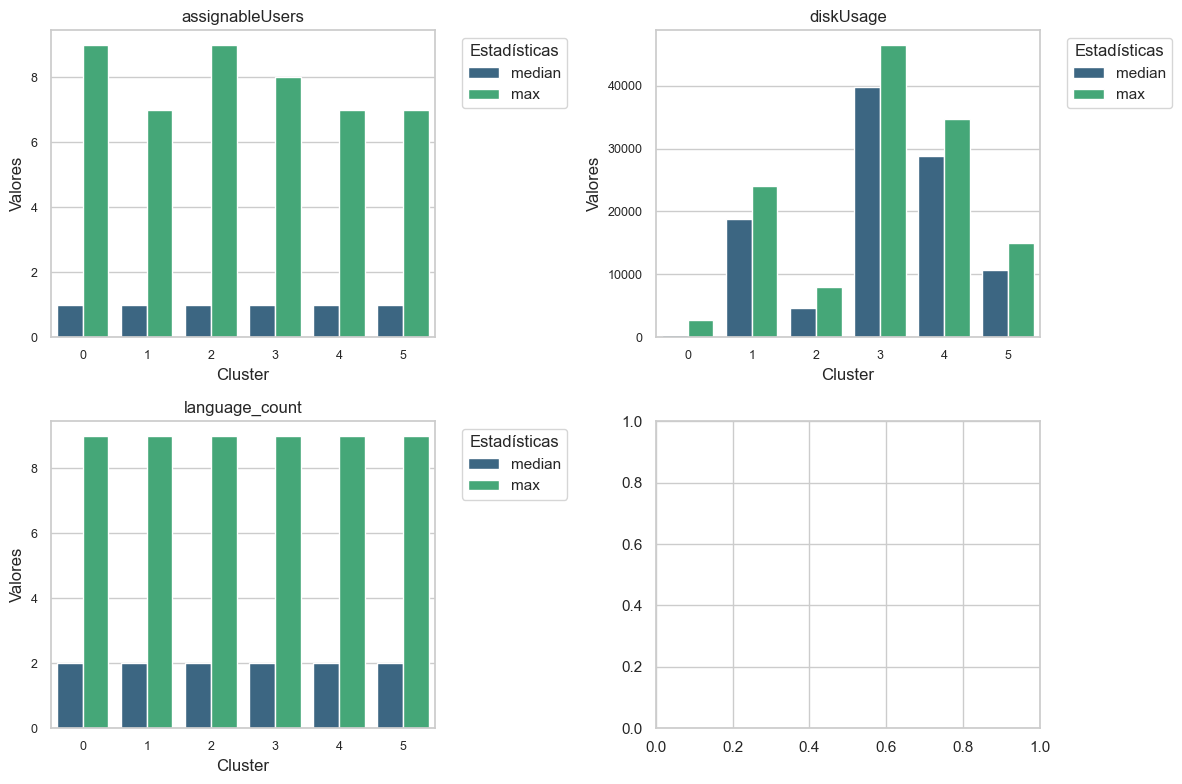

In [30]:
# Establecer estilo de gráficos
sns.set(style="whitegrid")

# Lista de estadísticas a mostrar
stats_to_plot = ['median', 'max']

# Filtrar las variables con diferencias significativas
significant_results = results_df[results_df['Conclusión'] == 'Significativo']

# Crear figura y subplots con 2 columnas
num_variables = len(significant_results['Variable'])
num_cols = 2
num_rows = (num_variables + num_cols - 1) // num_cols  # Calcula el número de filas necesarias
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, num_rows * 4), sharey=False)
axes = axes.flatten()  # Aplanar el array de ejes para fácil indexación

# Lista de variables significativas
variables = significant_results['Variable'].tolist()

# Recorrer cada variable y crear un subplot
for idx, variable in enumerate(variables):
    # Reorganizar los datos para la variable actual
    # Ajustar la referencia a los datos de estadística correcta
    data_to_plot = df_kmeans.groupby('cluster')[variable].agg(stats_to_plot).reset_index()

    # Convertir a formato largo para seaborn
    melted_data = pd.melt(data_to_plot, id_vars='cluster', var_name='Statistic', value_name='Value')

    # Configurar el gráfico en el subplot
    ax = axes[idx]
    sns.barplot(data=melted_data, x='cluster', y='Value', hue='Statistic', ax=ax, palette='viridis')

    ax.set_title(variable)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Valores')
    ax.legend(title='Estadísticas', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Ajustar la escala dinámica del eje y
    y_min, y_max = ax.get_ylim()  # Obtener límites actuales
    ax.set_ylim(max(0, y_min), y_max)  # Asegurarse que el límite inferior no sea negativo

# Ajustar layout
plt.tight_layout()
plt.show()


In [32]:
# Matriz Saaty para comparar atributos por importancia

# Paso 1: Definir las variables y la escala de Saaty
variables = columns_to_cluster
saaty_scale = {
    'equal': 1, 'bit_more': 3, 'much_more': 5,
    'very_much_more': 7, 'extremely_much_more': 9,
    'inv_sl': 1/3, 'inv_cl': 1/5, 'inv_st': 1/7, 'inv_ex': 1/9
}

# Inicializar matriz de comparación
n = len(variables)
comparison_matrix = np.ones((n, n))

# Relación de comparaciones
comparisons = {
    'assignableUsers': 'very_much_more', 'contributors': 'extremely_much_more',
    'releases': 'much_more', 'environments': 'much_more',
    'milestones': 'much_more', 'diskUsage': 'extremely_much_more',
    'language_count': 'extremely_much_more'
}

# Asignar importancia en la matriz según las comparaciones
for var, importance in comparisons.items():
    idx = variables.index(var)
    scale_value = saaty_scale[importance]
    for i in range(n):
        if i != idx:
            comparison_matrix[idx, i] = scale_value
            comparison_matrix[i, idx] = 1 / scale_value

# Paso 2: Normalizar la matriz y calcular prioridades
normalized_matrix = comparison_matrix / comparison_matrix.sum(axis=0)
priorities = normalized_matrix.mean(axis=1)

# Mostrar matriz de comparación y prioridades
comparison_df = pd.DataFrame(comparison_matrix, index=variables, columns=variables)
priority_df = pd.DataFrame({'Variable': variables, 'Importancia Relativa': priorities})

print("\nMatriz de comparación pareada:\n", comparison_df.round(2))
print("\nImportancia relativa calculada para cada variable:\n", priority_df)

# Paso 3: Calcular el índice de consistencia (opcional)
def calcular_indice_consistencia(matrix, priorities):
    weighted_sum = matrix @ priorities
    consistency_vector = weighted_sum / priorities
    lambda_max = consistency_vector.mean()
    ci = (lambda_max - n) / (n - 1)
    
    ri_values = {3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32}
    ri = ri_values.get(n, 1.32)
    return ci / ri

consistency_ratio = calcular_indice_consistencia(comparison_matrix, priorities)
print(f"\nRatio de consistencia (CR): {consistency_ratio:.2f}")
print("La matriz es consistentemente aceptable." if consistency_ratio < 0.1 else "La matriz tiene inconsistencias.")



Matriz de comparación pareada:
                         assignableUsers  contributors  deployments  diskUsage  \
assignableUsers                    1.00          0.11         7.00       0.11   
contributors                       9.00          1.00         9.00       0.11   
deployments                        0.14          0.11         1.00       0.11   
diskUsage                          9.00          9.00         9.00       1.00   
environments                       5.00          5.00         5.00       0.11   
milestones                         5.00          5.00         5.00       0.11   
releases                           5.00          5.00         5.00       0.11   
language_count                     9.00          9.00         9.00       9.00   
hasIssuesEnabled                   0.14          0.11         1.00       0.11   
hasProjectsEnabled                 0.14          0.11         1.00       0.11   
hasSponsorshipsEnabled             0.14          0.11         1.00       0.1